In [377]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [378]:
import warnings
warnings.filterwarnings('ignore')

In this script I will try to solve two business problems:

 - I will run a supervised algorithm to predict which are the prospective customers
 - Next I will try to predict what is the loan ammount the bank should offer a new customer
 - Let's see how the customer segmentation done here (tinyurl.com/k8a8wrsa) affects the analysis
 

## Reading and Segmentating the data

In [379]:
df = pd.read_csv('feature_engineered_loansdata.csv')

In [380]:
def clusterMapping(x):
    if x == 0:
        return 'seg1'
    elif x == 1:
        return 'seg2'
    else:
        return 'seg3'

In [381]:
df.cluster_id.value_counts()

1    152050
0    128902
2     23963
Name: cluster_id, dtype: int64

In [382]:
df['cluster_id'] = df['cluster_id'].apply(clusterMapping) 

# mapping the cluster levels

In [383]:
def vardefiner(df):
    lst = df.columns
    l = []
    l_i = []
    l_f = []
    l_c = []
    l_b = []
    for var in lst:
        if (len(df[var].unique())<=2)&(df[var].dtype!='O'):
            l_b.append(var)
        elif df[var].dtype=='O':
            l_c.append(var)
        elif df[var].dtype=='float':
            l_f.append(var)
        else:
            l_i.append(var)
        
    l = [l_b,l_c,l_f,l_i]
    return(l)      # a function to classify the variables

In [384]:
varlist = vardefiner(df)
binary_vars = varlist[0]
cat_vars = varlist[1]
float_vars = varlist[2]
int_vars = varlist[3] # segmenting the variables

In [385]:
df0 = df.copy()

## Feature Selection
 - In a previous street I have analysed the numeric types 
 - and selected the best performing numeric types
 - now I will rank the discrete and categorical types
 - this is the dataset of the selected numeric types

In [386]:
df_features = pd.read_csv('variable_ranking.csv')

In [387]:
df_features.set_index ('Unnamed: 0', inplace = True)

In [388]:
numcols = df_features.T.columns

In [389]:
numcols = list(numcols)

In [390]:
# let's remove the vaariable that are absent before customer acquisition

numcols.remove('AMT_CREDIT')
numcols.remove('EXP_TERM')
numcols.remove('PERCENT_OF_VALUE')

In [391]:
for colname in cat_vars:
    df[colname], _ = df[colname].factorize()
    
    # converting the categorical to numeric levels

In [392]:
X = df[binary_vars + cat_vars]
y = X.pop('NAME_CONTRACT_STATUS')

# first target variable(categorical)


In [393]:

discrete_features = X.dtypes == int

In [394]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# fit_transform

int_vars.remove('SK_ID_CURR')
int_vars.remove('SK_ID_PREV')

df[float_vars+int_vars] = scaler.fit_transform(df[float_vars+int_vars])



In [395]:
y1 = df['AMT_APPLICATION']

# second target variable(continuous)

In [396]:
from sklearn.feature_selection import mutual_info_regression
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [397]:
mi_scores1 = make_mi_scores(X, y, discrete_features) # for first target

In [398]:
mi_scores2 = make_mi_scores(X, y1, discrete_features) #for second target

In [399]:
def plot_mi_ca(scores):
    scores = scores.sort_values(ascending = True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title('Mutual Info Regressor for Categorical Target')

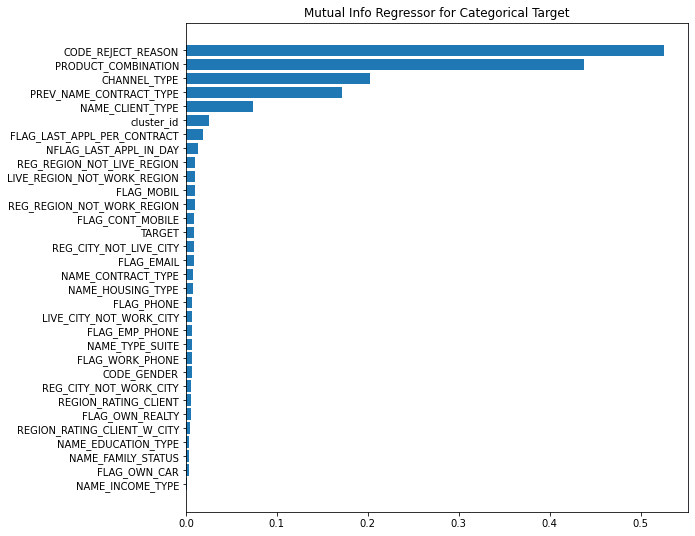

In [400]:
plt.figure(figsize = (9,9))
plot_mi_ca(mi_scores1)

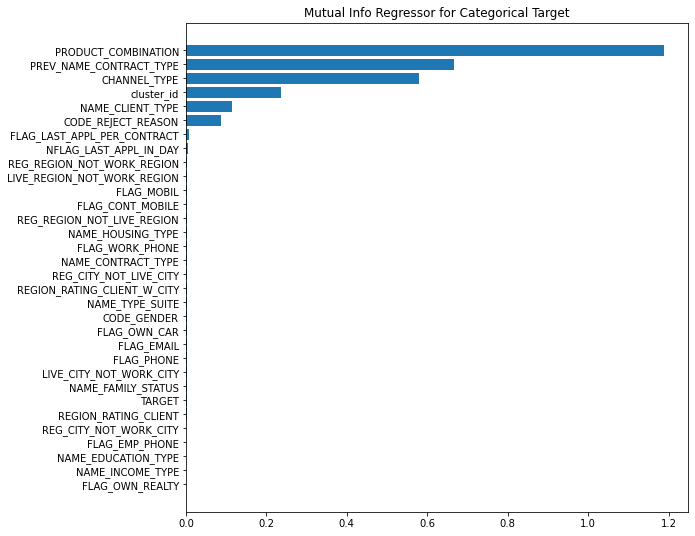

In [401]:
plt.figure(figsize = (9,9))
plot_mi_ca(mi_scores2)

## Encoding Target for Classification

(array([191940.,      0.,      0.,  52346.,      0.,      0.,  55641.,
             0.,      0.,   4988.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

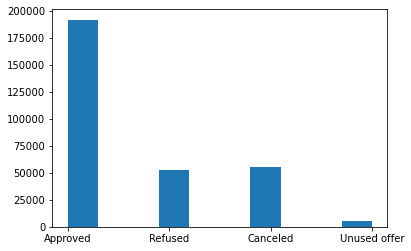

In [402]:
plt.hist(df0.NAME_CONTRACT_STATUS)

(array([2.4855e+05, 3.1189e+04, 1.0311e+04, 0.0000e+00, 4.9880e+03,
        2.2970e+03, 0.0000e+00, 6.8300e+03, 6.1000e+02, 1.4000e+02]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

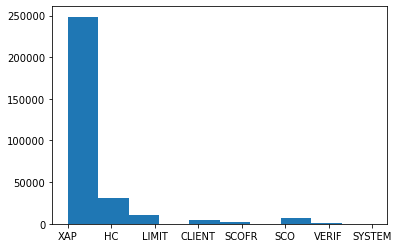

In [403]:
plt.hist(df0.CODE_REJECT_REASON)

In [404]:
df0['Cust_type'] = df0['NAME_CONTRACT_STATUS']

In [405]:
df0.drop(['NAME_CONTRACT_STATUS'], axis = 1, inplace = True)

In [406]:
df0['Cust_type'] .value_counts() # these are the four classes

Approved        191940
Canceled         55641
Refused          52346
Unused offer      4988
Name: Cust_type, dtype: int64

In [407]:
df1 = df0.copy()
df1.shape

(304915, 62)

### One important point
 - in my opinion this dataset is not beig enough for OneVsOne classification
 - OneVsOne would mean a total of 10 models
 - which would mean a little more than 30K points for each model
 - so the preferred method will be OneVsRest

# Classification Problem
 - classification of customers based on theri behaviour

## Dummy Preparation

In [408]:
# selecting the variable list

d_list = ['PRODUCT_COMBINATION', 'CHANNEL_TYPE', 'NAME_CLIENT_TYPE', 'cluster_id', 'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY', 'Cust_type']
for var in numcols:
    d_list.append(var)

In [409]:
df0 = df0[d_list]

In [410]:
varlist = vardefiner(df0)
binary_vars = varlist[0]
cat_vars = varlist[1]
float_vars = varlist[2]
int_vars = varlist[3]
cat_vars.remove('Cust_type')

In [411]:
def gettingdummies(df0,row):
    for item in row:
        dummy = pd.get_dummies(df0[item], drop_first = True).rename(columns = lambda x: item+'_'+str(x))
        df0 = pd.concat([df0, dummy], axis = 1)
        df0.drop([item], axis = 1, inplace = True)
    return df0

In [412]:
df0_dummy = gettingdummies(df0, cat_vars)

In [413]:
df0_dummy

,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,Cust_type,PREV_AMT_CREDIT,REGION_POPULATION_RELATIVE,CREDIT_DIF,TOTAL_DOCUMENTS,PREV_HOUR_APPR_PROCESS_START,EXT_SOURCE_2,PREV_WEEKDAY_APPR_PROCESS_START,...,CHANNEL_TYPE_Channel of corporate sales,CHANNEL_TYPE_Contact center,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Credit and cash offices,CHANNEL_TYPE_Regional / Local,CHANNEL_TYPE_Stone,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,cluster_id_seg2,cluster_id_seg3
0,1,1,Approved,17145.0,0.018801,-389452.5,1,15,0.262949,6,...,0,0,1,0,0,0,0,1,1,0
1,1,1,Approved,679671.0,0.003541,-613831.5,1,11,0.622246,4,...,0,1,0,0,0,0,0,1,0,1
2,1,1,Approved,136444.5,0.010032,1444.5,0,11,0.555912,2,...,0,0,0,1,0,0,0,1,1,0
3,1,1,Approved,470790.0,0.008019,158107.5,1,7,0.650442,1,...,0,0,0,1,0,0,0,1,0,0
4,1,1,Refused,404055.0,0.028663,-108945.0,1,9,0.322738,4,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304910,1,1,Canceled,0.0,0.032561,-254700.0,1,11,0.681632,2,...,0,0,0,1,0,0,0,1,1,0
304911,1,1,Approved,167895.0,0.025164,-101655.0,1,18,0.115992,3,...,0,0,0,1,0,0,0,1,0,0
304912,1,1,Approved,491580.0,0.005002,-186084.0,1,12,0.535722,3,...,0,0,0,1,0,0,0,1,0,0
304913,1,1,Canceled,0.0,0.005313,-370107.0,1,18,0.514163,2,...,0,0,0,1,0,0,0,1,1,0


## Data Preparation

In [414]:
y_c = df0_dummy.pop('Cust_type')

In [415]:
X_c = df0_dummy

In [416]:
X_c

,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,PREV_AMT_CREDIT,REGION_POPULATION_RELATIVE,CREDIT_DIF,TOTAL_DOCUMENTS,PREV_HOUR_APPR_PROCESS_START,EXT_SOURCE_2,PREV_WEEKDAY_APPR_PROCESS_START,AGE_GRP,...,CHANNEL_TYPE_Channel of corporate sales,CHANNEL_TYPE_Contact center,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Credit and cash offices,CHANNEL_TYPE_Regional / Local,CHANNEL_TYPE_Stone,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,cluster_id_seg2,cluster_id_seg3
0,1,1,17145.0,0.018801,-389452.5,1,15,0.262949,6,2,...,0,0,1,0,0,0,0,1,1,0
1,1,1,679671.0,0.003541,-613831.5,1,11,0.622246,4,4,...,0,1,0,0,0,0,0,1,0,1
2,1,1,136444.5,0.010032,1444.5,0,11,0.555912,2,4,...,0,0,0,1,0,0,0,1,1,0
3,1,1,470790.0,0.008019,158107.5,1,7,0.650442,1,4,...,0,0,0,1,0,0,0,1,0,0
4,1,1,404055.0,0.028663,-108945.0,1,9,0.322738,4,5,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304910,1,1,0.0,0.032561,-254700.0,1,11,0.681632,2,2,...,0,0,0,1,0,0,0,1,1,0
304911,1,1,167895.0,0.025164,-101655.0,1,18,0.115992,3,5,...,0,0,0,1,0,0,0,1,0,0
304912,1,1,491580.0,0.005002,-186084.0,1,12,0.535722,3,3,...,0,0,0,1,0,0,0,1,0,0
304913,1,1,0.0,0.005313,-370107.0,1,18,0.514163,2,2,...,0,0,0,1,0,0,0,1,1,0


In [417]:
from sklearn.model_selection import train_test_split

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c,y_c, test_size = 0.3, random_state = 10)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled_c = scaler.fit_transform(X_train_c)
X_test_scaled_c = scaler.transform(X_test_c)

## Model Building

In [418]:
from sklearn.linear_model import LogisticRegression 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [419]:


LR = LogisticRegression()
oneVsrest = OneVsRestClassifier(LR) 

# I will use to onevsrest classifier with LogisticRegression


oneVsrest.fit(X_train_scaled_c, y_train_c)

OneVsRestClassifier(estimator=LogisticRegression())

In [420]:
prediction_ovsr_train = oneVsrest.predict(X_train_scaled_c)


print(accuracy_score(y_train_c, prediction_ovsr_train)*100)


print(classification_report(y_train_c, prediction_ovsr_train))

81.77052098950524
              precision    recall  f1-score   support

    Approved       0.82      0.97      0.89    134378
    Canceled       0.85      0.96      0.90     38878
     Refused       0.68      0.19      0.30     36674
Unused offer       0.00      0.00      0.00      3510

    accuracy                           0.82    213440
   macro avg       0.59      0.53      0.52    213440
weighted avg       0.79      0.82      0.77    213440



## Model Prediction

In [421]:

prediction_ovsr = oneVsrest.predict(X_test_scaled_c)

# Evaluating the model

print(accuracy_score(y_test_c, prediction_ovsr)*100)
print(classification_report(y_test_c, prediction_ovsr))

81.84421973216726
              precision    recall  f1-score   support

    Approved       0.82      0.97      0.89     57562
    Canceled       0.85      0.96      0.91     16763
     Refused       0.68      0.19      0.30     15672
Unused offer       0.00      0.00      0.00      1478

    accuracy                           0.82     91475
   macro avg       0.59      0.53      0.52     91475
weighted avg       0.79      0.82      0.78     91475



In [422]:
X_test_c['Scaled_features'] = X_test_scaled_c.tolist()

X_test_c['Actual'] = y_test_c

#target prediction

X_test_c['prediction_oneVsrest'] = prediction_ovsr
# prediction

X_test_c['prob_pred'] = oneVsrest.predict_proba(X_test_scaled_c).tolist()

#OnevsRest  probabilities

X_test_c['prob_pred_Approved'] = oneVsrest.predict_proba(X_test_scaled_c)[:,0].tolist()
X_test_c['prob_pred_Canceled'] = oneVsrest.predict_proba(X_test_scaled_c)[:,1].tolist()
X_test_c['prob_pred_Refused'] = oneVsrest.predict_proba(X_test_scaled_c)[:,2].tolist()
X_test_c['prob_pred_Unused_offer'] = oneVsrest.predict_proba(X_test_scaled_c)[:,3].tolist()



X_test_c.head()

,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,PREV_AMT_CREDIT,REGION_POPULATION_RELATIVE,CREDIT_DIF,TOTAL_DOCUMENTS,PREV_HOUR_APPR_PROCESS_START,EXT_SOURCE_2,PREV_WEEKDAY_APPR_PROCESS_START,AGE_GRP,...,cluster_id_seg2,cluster_id_seg3,Scaled_features,Actual,prediction_oneVsrest,prob_pred,prob_pred_Approved,prob_pred_Canceled,prob_pred_Refused,prob_pred_Unused_offer
187458,1,1,765000.0,0.011703,-702612.0,2,11,0.676519,4,3,...,0,1,"[0.07181018406860838, 0.059023693130060964, 1....",Approved,Approved,"[0.7279441391865011, 0.003562053952316939, 0.2...",0.727944,0.003562,0.268480,0.000014
122452,1,1,46642.5,0.018209,-403357.5,1,15,0.442629,2,3,...,1,0,"[0.07181018406860838, 0.059023693130060964, -0...",Approved,Approved,"[0.6753074211359653, 0.0025243935431424956, 0....",0.675307,0.002524,0.165876,0.156292
233767,1,1,215568.0,0.032561,-234432.0,1,9,0.741203,2,4,...,1,0,"[0.07181018406860838, 0.059023693130060964, 0....",Approved,Approved,"[0.7565289713177331, 0.002227621417723627, 0.2...",0.756529,0.002228,0.241240,0.000003
175853,1,1,540000.0,0.019101,268933.5,1,19,0.479207,5,3,...,1,0,"[0.07181018406860838, 0.059023693130060964, 1....",Approved,Approved,"[0.7335496162981444, 0.00023694130261846355, 0...",0.733550,0.000237,0.266209,0.000004
233447,1,1,19921.5,0.008019,-115078.5,2,9,0.371074,4,2,...,1,0,"[0.07181018406860838, 0.059023693130060964, -0...",Approved,Approved,"[0.720543490158271, 0.002800855715105369, 0.16...",0.720543,0.002801,0.160164,0.116492


In [423]:
# Classes for which individual models are created
print(oneVsrest.classes_)
#Coefficient matrix for all the models created

print(oneVsrest.coef_.shape)
#Intercept values for all the models created
print(oneVsrest.intercept_)

#Coefficient values for all the models created
coeff_array = oneVsrest.coef_
print(oneVsrest.coef_)

['Approved' 'Canceled' 'Refused' 'Unused offer']
(4, 39)
[[-0.39875899]
 [-4.82405841]
 [-1.80735351]
 [-8.09108945]]
[[ 9.57481698e-01 -1.40457030e-01 -2.32757154e-01 -3.45696836e-03
  -5.99062430e-03  4.86067528e-03 -2.36590354e-02  2.73932542e-03
   9.56058684e-03  3.21817031e-05  7.39081478e-03 -7.06994785e-03
   5.47754217e-01 -3.11289984e+00  2.45759910e-01  6.69191630e-02
   1.27190695e-01  4.60494145e-01  5.89254988e-01  7.56988279e-01
   5.54351700e-01  3.24067990e-01  3.95806915e-01  1.57038984e-01
   2.90709100e-01  2.44110498e-01  1.72772747e-01  8.27350260e-02
   2.48738997e-02  3.57885648e-02 -2.67704317e-02  5.49050801e-01
   8.76803286e-02  4.00582472e-01  5.30206506e-01 -3.33082627e-01
  -8.11605154e-01  7.54967769e-04 -2.05126406e-02]
 [ 4.88157985e-01  2.37518343e-01 -9.92347453e-01  6.83999421e-03
   2.04137453e-03 -1.26400909e-02 -2.73352812e-02  2.84555990e-02
  -1.08213107e-02  2.99489547e-03  5.34871353e-03  3.91131368e-03
  -1.30009591e+00  6.52029930e-01 -1.12

# Regression Problem
- What is the loan amt. the Bank should offer a customer?

In [424]:
df2 = df1.copy()
df1.head()

,Unnamed: 0,SK_ID_CURR,SK_ID_PREV,PREV_NAME_CONTRACT_TYPE,AMT_APPLICATION,PREV_AMT_CREDIT,PREV_WEEKDAY_APPR_PROCESS_START,PREV_HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,...,EXP_TERM,CREDIT_DIF,PERCENT_OF_VALUE,INCOME_F_ADJUSTED,INCOME_ADJUSTED,YEARS_EMPLOYED,AGE_GRP,SK_ID_CURR.1,cluster_id,Cust_type
0,0,100002,2030495,Consumer loans,17145.0,17145.0,6,15,1,1,...,0.69,-389452.5,4.88,101250.0,202500.0,2.0,2,100002,seg2,Approved
1,1,100003,2802425,Cash loans,607500.0,679671.0,4,11,1,1,...,17.02,-613831.5,53.78,90000.0,270000.0,3.0,4,100003,seg3,Approved
2,2,100004,2523466,Cash loans,112500.0,136444.5,2,11,1,1,...,16.67,1444.5,83.33,33750.0,67500.0,1.0,4,100004,seg2,Approved
3,3,100006,2819243,Cash loans,450000.0,470790.0,1,7,1,1,...,15.16,158107.5,151.52,45000.0,135000.0,8.0,4,100006,seg1,Approved
4,4,100007,1784265,Cash loans,337500.0,404055.0,4,9,1,1,...,15.44,-108945.0,65.79,60750.0,121500.0,8.0,5,100007,seg1,Refused


In [425]:
f_list = mi_scores2[2:4]

# only these information from the analysied categorical variables will be availabe during prediction

In [426]:
f = list(f_list.index)

In [427]:
l = ['REGION_POPULATION_RELATIVE', 'TOTAL_DOCUMENTS', 'EXT_SOURCE_2', 'AGE_GRP', 'YEARS_EMPLOYED', 'AMT_APPLICATION' ]

# only these information from the analysied numeric variables will be availabe during prediction

In [428]:
numcols

['PREV_AMT_CREDIT',
 'REGION_POPULATION_RELATIVE',
 'CREDIT_DIF',
 'TOTAL_DOCUMENTS',
 'PREV_HOUR_APPR_PROCESS_START',
 'EXT_SOURCE_2',
 'PREV_WEEKDAY_APPR_PROCESS_START',
 'AGE_GRP',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'YEARS_EMPLOYED']

In [429]:
numcols.remove('CREDIT_DIF') # we won't have the credit value for new customers

In [430]:
reg_vars = f+l
reg_vars.append('AMT_APPLICATION')

In [431]:
df_r = df1[reg_vars]


###  Dummy Preparation

In [432]:
def gettingdummies(df0,row):
    for item in row:
        dummy = pd.get_dummies(df0[item], drop_first = True).rename(columns = lambda x: item+'_'+str(x))
        df0 = pd.concat([df0, dummy], axis = 1)
        df0.drop([item], axis = 1, inplace = True)
    return df0

In [433]:
df1 = gettingdummies(df_r,f)


In [434]:
df1.dtypes

REGION_POPULATION_RELATIVE                 float64
TOTAL_DOCUMENTS                              int64
EXT_SOURCE_2                               float64
AGE_GRP                                      int64
YEARS_EMPLOYED                             float64
AMT_APPLICATION                            float64
AMT_APPLICATION                            float64
CHANNEL_TYPE_Car dealer                      uint8
CHANNEL_TYPE_Channel of corporate sales      uint8
CHANNEL_TYPE_Contact center                  uint8
CHANNEL_TYPE_Country-wide                    uint8
CHANNEL_TYPE_Credit and cash offices         uint8
CHANNEL_TYPE_Regional / Local                uint8
CHANNEL_TYPE_Stone                           uint8
cluster_id_seg2                              uint8
cluster_id_seg3                              uint8
dtype: object

### Data Preparation

In [435]:
from sklearn.model_selection import train_test_split

In [436]:
np.random.seed(0)
df_train, df_test = train_test_split(df1, train_size = 0.8, test_size = 0.2, random_state = 100)

In [437]:
from sklearn.preprocessing import MinMaxScaler

In [438]:
scaler = MinMaxScaler()
df_train[l] = scaler.fit_transform(df_train[l])
df_test[l] = scaler.transform(df_test[l])

In [439]:
y_train_r = df_train.pop('AMT_APPLICATION')
y_test_r = df_test.pop('AMT_APPLICATION')
X_train_r = df_train
X_test_r = df_test

In [440]:
df_train

,REGION_POPULATION_RELATIVE,TOTAL_DOCUMENTS,EXT_SOURCE_2,AGE_GRP,YEARS_EMPLOYED,CHANNEL_TYPE_Car dealer,CHANNEL_TYPE_Channel of corporate sales,CHANNEL_TYPE_Contact center,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Credit and cash offices,CHANNEL_TYPE_Regional / Local,CHANNEL_TYPE_Stone,cluster_id_seg2,cluster_id_seg3
43285,0.491595,0.25,0.789137,0.50,0.145833,0,0,0,1,0,0,0,0,0
251502,0.268617,0.25,0.732782,0.50,0.083333,0,0,0,1,0,0,0,1,0
174909,0.206749,0.25,0.740438,0.75,0.062500,0,0,0,0,1,0,0,0,1
97632,0.635991,0.25,0.836942,0.25,0.041667,0,0,0,0,1,0,0,0,1
169724,0.069553,0.25,0.575265,0.50,0.250000,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65615,0.081932,0.25,0.643982,0.25,0.062500,0,0,0,1,0,0,0,1,0
253799,0.097483,0.25,0.737803,0.50,0.062500,0,0,0,0,1,0,0,1,0
210755,0.491595,0.25,0.887663,0.50,0.125000,0,0,0,0,1,0,0,0,1
56088,0.421848,0.25,0.583544,0.25,0.020833,0,0,0,1,0,0,0,1,0


## Model Building

## Decision Tree Regressor

In [441]:
from sklearn.tree import DecisionTreeRegressor

#### Hyper-parameter Tuning

In [442]:
dt = DecisionTreeRegressor(random_state=42)

In [443]:
from sklearn.model_selection import GridSearchCV

In [444]:
params = {'splitter':['best'],
    'max_depth': [9, 13, 19, 27],
    'min_samples_leaf': [33, 67, 101, 151],
           "max_features":["auto","sqrt"]
}

In [445]:
?GridSearchCV

In [446]:
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, verbose=3, scoring = "neg_mean_squared_error")

In [447]:
%%time
grid_search.fit(X_train_r, y_train_r)

Fitting 4 folds for each of 32 candidates, totalling 128 fits
[CV 1/4] END max_depth=9, max_features=auto, min_samples_leaf=33, splitter=best;, score=-0.002 total time=   1.0s
[CV 2/4] END max_depth=9, max_features=auto, min_samples_leaf=33, splitter=best;, score=-0.002 total time=   0.9s
[CV 3/4] END max_depth=9, max_features=auto, min_samples_leaf=33, splitter=best;, score=-0.002 total time=   0.6s
[CV 4/4] END max_depth=9, max_features=auto, min_samples_leaf=33, splitter=best;, score=-0.002 total time=   0.5s
[CV 1/4] END max_depth=9, max_features=auto, min_samples_leaf=67, splitter=best;, score=-0.002 total time=   0.7s
[CV 2/4] END max_depth=9, max_features=auto, min_samples_leaf=67, splitter=best;, score=-0.002 total time=   0.8s
[CV 3/4] END max_depth=9, max_features=auto, min_samples_leaf=67, splitter=best;, score=-0.002 total time=   0.5s
[CV 4/4] END max_depth=9, max_features=auto, min_samples_leaf=67, splitter=best;, score=-0.002 total time=   0.6s
[CV 1/4] END max_depth=9, 

[CV 4/4] END max_depth=19, max_features=auto, min_samples_leaf=67, splitter=best;, score=-0.002 total time=   1.4s
[CV 1/4] END max_depth=19, max_features=auto, min_samples_leaf=101, splitter=best;, score=-0.002 total time=   0.8s
[CV 2/4] END max_depth=19, max_features=auto, min_samples_leaf=101, splitter=best;, score=-0.002 total time=   0.8s
[CV 3/4] END max_depth=19, max_features=auto, min_samples_leaf=101, splitter=best;, score=-0.002 total time=   0.7s
[CV 4/4] END max_depth=19, max_features=auto, min_samples_leaf=101, splitter=best;, score=-0.002 total time=   0.8s
[CV 1/4] END max_depth=19, max_features=auto, min_samples_leaf=151, splitter=best;, score=-0.002 total time=   0.7s
[CV 2/4] END max_depth=19, max_features=auto, min_samples_leaf=151, splitter=best;, score=-0.002 total time=   1.0s
[CV 3/4] END max_depth=19, max_features=auto, min_samples_leaf=151, splitter=best;, score=-0.002 total time=   0.7s
[CV 4/4] END max_depth=19, max_features=auto, min_samples_leaf=151, split

GridSearchCV(cv=4, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [9, 13, 19, 27],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [33, 67, 101, 151],
                         'splitter': ['best']},
             scoring='neg_mean_squared_error', verbose=3)

In [448]:
grid_search.best_estimator_

DecisionTreeRegressor(max_depth=9, max_features='auto', min_samples_leaf=151,
                      random_state=42)

In [449]:
decision = grid_search.best_estimator_

In [450]:
y_pred = decision.predict(X_test_r)

In [451]:
from sklearn.metrics import r2_score

r_test = r2_score(y_test_r, y_pred)
y_pred_train = decision.predict(X_train_r)
r_train = r2_score(y_train_r, y_pred_train)

In [452]:
print('R^2 score of train data{}'.format(r_train))
print('R^2 score of test data{}'.format(r_test))

R^2 score of train data0.6586430806449444
R^2 score of test data0.6516971436155266


### Model Evaluation

Text(0.5, 0, 'Errors')

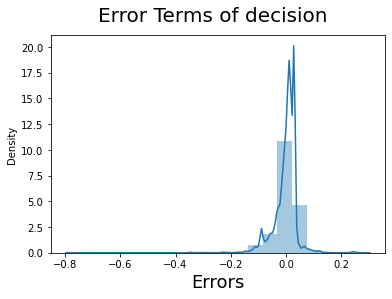

In [453]:
fig = plt.figure()
sns.distplot((y_pred - y_test_r), bins = 20)
fig.suptitle('Error Terms of decision', fontsize = 20)                  # This does not look good
plt.xlabel('Errors', fontsize = 18)

# this is not a normal distribution but we can work with it

Text(0, 0.5, 'y_pred')

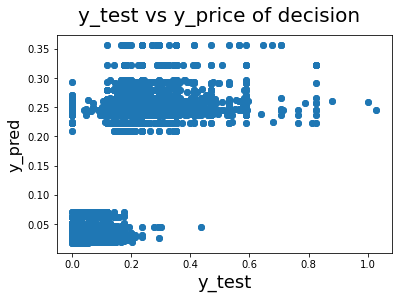

In [454]:
fig = plt.figure()
plt.scatter(y_test_r, y_pred)
fig.suptitle('y_test vs y_price of decision', fontsize=20)              
plt.xlabel('y_test', fontsize=18)                          
plt.ylabel('y_pred', fontsize=16) 

# we see some kind of linearity

Text(0, 0.5, 'y_pred')

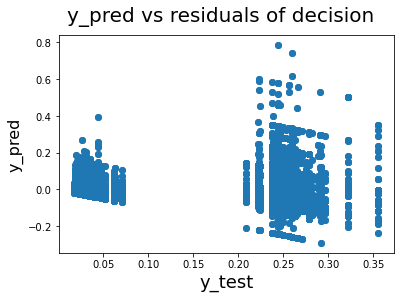

In [455]:
fig = plt.figure()
res_y = y_test_r - y_pred
plt.scatter(y_pred,res_y)
fig.suptitle('y_pred vs residuals of decision', fontsize=20)              
plt.xlabel('y_test', fontsize=18)                          
plt.ylabel('y_pred', fontsize=16) 

# the residuals are fairly random

### Random Forest

In [456]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(X_train_r, y_train_r)
melb_preds = forest_model.predict(X_test_r)
print(mean_absolute_error(y_test_r, melb_preds))

0.029783032952637064


In [457]:

print('R^2 score of RandomForest{}'.format(r2_score(y_test_r, melb_preds)))
# The decision tree was performing better

R^2 score of RandomForest0.6094042090640448



### Linear Regression

In [458]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [459]:
#from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFE

lm = LinearRegression()
lm.fit(X_train_r, y_train_r)

rfe = RFE(estimator = LinearRegression(), n_features_to_select = 7)             
rfe = rfe.fit(X_train_r, y_train_r)

In [460]:
list(zip(X_train_r.columns,rfe.support_,rfe.ranking_))

[('REGION_POPULATION_RELATIVE', False, 8),
 ('TOTAL_DOCUMENTS', False, 4),
 ('EXT_SOURCE_2', False, 7),
 ('AGE_GRP', False, 5),
 ('YEARS_EMPLOYED', False, 3),
 ('CHANNEL_TYPE_Car dealer', True, 1),
 ('CHANNEL_TYPE_Channel of corporate sales', True, 1),
 ('CHANNEL_TYPE_Contact center', False, 2),
 ('CHANNEL_TYPE_Country-wide', True, 1),
 ('CHANNEL_TYPE_Credit and cash offices', True, 1),
 ('CHANNEL_TYPE_Regional / Local', True, 1),
 ('CHANNEL_TYPE_Stone', True, 1),
 ('cluster_id_seg2', False, 6),
 ('cluster_id_seg3', True, 1)]

In [461]:
col = X_train_r.columns[rfe.support_]
col

Index(['CHANNEL_TYPE_Car dealer', 'CHANNEL_TYPE_Channel of corporate sales',
       'CHANNEL_TYPE_Country-wide', 'CHANNEL_TYPE_Credit and cash offices',
       'CHANNEL_TYPE_Regional / Local', 'CHANNEL_TYPE_Stone',
       'cluster_id_seg3'],
      dtype='object')

In [462]:
X_train_rfe = X_train_r[col]
X_test_rfe = X_test_r[col]

In [463]:
import statsmodels.api as sm

X_train_sm = sm.add_constant(X_train_rfe)

In [464]:
y_train_r = y_train_r.T.drop_duplicates().T
lr = sm.OLS(y_train_r, X_train_sm).fit()


In [465]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        AMT_APPLICATION   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                 6.626e+04
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        08:07:35   Log-Likelihood:             4.1518e+05
No. Observations:              243932   AIC:                        -8.304e+05
Df Residuals:                  243924   BIC:                        -8.303e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       0.0365      0.000    106.521      0.000       0.036       0.037
CHANNEL_TYPE_Car dealer                     0.1680      0.005     31.781      0.000       0.158       0.178
CHANNEL_TYPE_Channel of corporate sales     0.0498      0.001     34.661      0.000       0.047       0.053
CHANNEL_TYPE_Country-wide                  -0.0144      0.000    -38.025      0.000      -0.015      -0.014
CHANNEL_TYPE_Credit and cash offices       -0.0070      0.000    -19.098      0.000      -0.008      -0.006
CHANNEL_TYPE_Regional / Local              -0.0093      0.000    -19.186      0.000      -0.010      -0.008
CHANNEL_TYPE_Stone                         -0.0094      0.000    -22.348      0.000      -0.010      -0.009
cluster_id_seg3                             0.2194      0.000    636.033      0.000       0.219       0.220
==============================================================================
Omnibus:                   129104.914   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3726778.718
Skew:                           1.992   Prob(JB):                         0.00
Kurtosis:                      21.730   Cond. No.                         67.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [466]:
X_test_sm = sm.add_constant(X_test_rfe)


In [467]:
linreg_pred = lr.predict(X_test_sm)


In [468]:
linreg_pred_train = lr.predict(X_train_sm)

In [469]:
y_test_r = y_test_r.T.drop_duplicates().T




In [470]:
print('R^2 of linear regression of test set is {}'.format(r2_score(y_test_r, linreg_pred)))
print('R^2 of linear regression of train set is {}'.format(r2_score(y_train_r, linreg_pred_train)))

R^2 of linear regression of test set is 0.6523527100375333
R^2 of linear regression of train set is 0.6553603668672482


In [471]:
X_train_rfe.drop(['cluster_id_seg3'], axis = 1, inplace = True)
X_test_rfe.drop(['cluster_id_seg3'], axis = 1, inplace = True)


# now what happens if we drop the cluster variable?

In [472]:
X_train_sm2 = sm.add_constant(X_train_rfe)
X_test_sm2 = sm.add_constant(X_test_rfe)
lr2 = sm.OLS(y_train_r, X_train_sm2).fit()
X_test_sm2 = sm.add_constant(X_test_rfe)
linreg_pred2 = lr2.predict(X_test_sm2)
linreg_pred_train2 = lr2.predict(X_train_sm2)

In [473]:
print('R^2 of linear regression of test set is {}'.format(r2_score(y_test_r, linreg_pred2)))

R^2 of linear regression of test set is 0.08426426976988632


In [474]:
print('R^2 of linear regression of train set is {}'.format(r2_score(y_train_r, linreg_pred_train2)))


# the model loses almost all its explainability
# and CANNEL_TYPE emerges as a major variable to explain customer demands.

R^2 of linear regression of train set is 0.08378918588626127


### Although this is not a good prediction, this is better than no prediction at all
   - We can find out what is the loan amt to offer
   - without the cluster_id dummy the linear regression loses almost all its performance
   - So the segmentation done is the previous section was significant
   - in conclusion, the solution to the regression problem is not satisfactory, but it can be used to predict the estimated credit
   - and the solutions of both the classification and the regression problem cannot be found for the same dataset. 